# Directed diffusion

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import scanpy as sc
from scanpy.tools._dpt import DPT

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
from scipy.stats import logistic
import seaborn as sns

import os
import pickle

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from skin_ilc_util import mpl_set_default_style, cm_gray_red, day_palette, \
    CappedNormalize, cm_black_white_discrete, subplots_fixed_width, \
    mpl_set_default_style, cm_purple

In [4]:
mpl_set_default_style(matplotlib.rcParams)

## Directed diffusion functions

In [5]:
def determine_logistic_params(pseudotime, opt_cells_forward, max_cells_back):
    """
    Fit the logistic parameters to weight the transition matrix with.
    """
    
    asymptote = 0.01
    pseudotime = np.sort(pseudotime)
    mean_time_back = np.mean(pseudotime[:-max_cells_back] - pseudotime[max_cells_back:])
    mean_time_forward = np.mean(pseudotime[opt_cells_forward:] - pseudotime[:-opt_cells_forward])
    x0 = np.mean([mean_time_back, mean_time_forward])
    k = (x0 - mean_time_forward) / np.log(asymptote)
    
    xs = np.linspace(2*mean_time_back, 2*mean_time_forward, 100)
    plt.figure()
    plt.plot(xs, logistic.cdf(-xs, x0, k), '-')
    plt.xlabel('pseudotime difference')
    plt.ylabel('multiplicative weight')
    plt.axvline(0)
    plt.show()
    
    return (x0, k)

In [6]:
def build_prob_dict(mat):
    """
    Helper function to build the dictionary that is traversed during the walks
    """
    
    indices = {}
    probs = {}
    
    nn = mat.nonzero()
    for i in range(mat.shape[0]):
        start, end = (mat.indptr[i], mat.indptr[i+1])
        indices[i] = nn[1][start:end]
        probs[i] = np.cumsum(mat.data[start:end])
        probs[i] /= probs[i][-1]
    
    return {"n_cells" : mat.shape[0], "indices" : indices, "probabilities" : probs}

In [7]:
def build_weighted_transition_matrix(T, pseudotime, variant = 'logistic', logistic_params = None):
    """
    Builds the weighted transition matrix
    """
    
    # Subtracting things in series is a bad idea, so use array
    if type(pseudotime) is pd.core.series.Series:
        pseudotime = pseudotime.values
        
    (x0, k) = logistic_params
    S = T.copy() # results matrix
    nn = S.nonzero()
    
    if variant == 'logistic':
        M = T.copy() # hold the entries of the logistic function
        # Multiply by logistic
        M.data = logistic.cdf(pseudotime[nn[0]] - pseudotime[nn[1]], x0, k)
        S.data *= M.data
    elif variant == 'strict':
        S.data *= (-pseudotime[nn[0]] + pseudotime[nn[1]]) < 0
    else:
        raise Exception("Only 'logistic' and 'strict' are possible variants.")
        
    
    # Normalize
    for i in range(S.shape[0]):
        S.data[S.indptr[i]:S.indptr[i+1]] /= np.sum(S.data[S.indptr[i]:S.indptr[i+1]])
    
    # Clean up the matrix
    S.eliminate_zeros()
        
    #return S
    return build_prob_dict(S)

In [8]:
def sample_backwards_walk(transitions, start_indices, end_indices):
    
    """
    Core function to sample walks
    """
    
    idx = np.random.choice(start_indices)
    walk = [idx]
    while idx not in end_indices:
        res = np.digitize(np.random.rand(), transitions["probabilities"][idx])
        idx = transitions["indices"][idx][np.digitize(np.random.rand(), transitions["probabilities"][idx])]
        walk.append(idx)
    
    return walk

In [9]:
def run_walks(transitions, start_indices, end_indices, iters, check_every = 1000, verbose = False):
    """
    Simulate a fixed number of walks
    """
    
    cell_freqs = {i : 0 for i in range(transitions["n_cells"])}
    cell_positions = {i : [] for i in range(transitions["n_cells"])}
    cell_pos_old = None
    rel_changes = []
    
    def compute_results(transitions, cell_freqs, cell_positions, iters):
        cell_freq_arr = np.full(transitions['n_cells'], np.nan)
        cell_pos_arr = np.full(transitions['n_cells'], np.nan)
        for k in cell_freqs: cell_freq_arr[k] = cell_freqs[k] / iters
        for k in cell_positions: cell_pos_arr[k] = np.mean(cell_positions[k])
        return (cell_freq_arr, cell_pos_arr)
    
    for i in range(iters):
        if verbose and (i % 1000 == 0):
            print("Iteration {}".format(i))
            
        walk = sample_backwards_walk(transitions, start_indices, end_indices)
        #print(len(walk))
        positions = np.linspace(0, 1, len(walk))
        for (idx, pos) in zip(walk, positions):
            cell_freqs[idx] += 1
            cell_positions[idx].append(pos)
            
        if (i + 1) % check_every == 0:
            (_, cell_pos_arr) = compute_results(transitions, cell_freqs, cell_positions, i + 1)
            cell_pos_arr = np.nan_to_num(cell_pos_arr, nan = 0)
            if cell_pos_old is None:
                cell_pos_old = cell_pos_arr
            else:
                rel_changes.append(np.linalg.norm(cell_pos_arr - cell_pos_old) / np.linalg.norm(cell_pos_arr))
                cell_pos_old = cell_pos_arr
    
    (cell_freq_arr, cell_pos_arr) = compute_results(transitions, cell_freqs, cell_positions, iters)
    
    return (cell_freq_arr, cell_pos_arr, rel_changes)

In [10]:
def run_walks_cached(transitions, start_indices, end_indices, iters,
                     check_every = 1000, fname = None, reset = False,
                     verbose = False):
    """
    Wrapper function that loads the results if a cache file is available
    """
    
    if fname is None:
        return run_walks(transitions, start_indices, end_indices, iters, check_every = check_every,
                        verbose = verbse)
    else:
        if os.path.exists(fname) and not reset:
            with open(fname, 'rb') as transition_file:
                return pickle.load(transition_file)
        else:
            np.random.seed(0)
            (freqs, pos, rel_changes) = run_walks(transitions, start_indices, end_indices, iters)
            with open(fname, 'wb') as transition_file:
                print("Pickling")
                pickle.dump((freqs, pos, rel_changes), transition_file)
            return (freqs, pos, rel_changes)

In [11]:
def average_pseudotime(adata, idcs, n_dcs = 10):
    """
    Average pseudotime over a set of cells
    """
    
    pt_mat = np.zeros((adata.shape[0], len(idcs)))
    for (i, idx) in enumerate(idcs):
        adata.uns['iroot'] = idx
        sc.tl.dpt(adata, n_dcs)
        pt_mat[:,i] = adata.obs['dpt_pseudotime']
    return np.mean(pt_mat, axis = 1)

## Selection functions

In [12]:
def select_by_dc(adata, target_dc, pick_high = True, pick_elems = 20,
                 components = '1,2', plot = True, name = 'iroot', write_to_adata = True):
    """
    Select cells highest/lowest in a particular diffusion component and plot
    """
    
    dc_vals = np.argsort(adata.obsm['X_diffmap'][:,target_dc])
    root_idx = dc_vals[-pick_elems:] if pick_high else dc_vals[:pick_elems]
    if write_to_adata:
        adata.obs[name] = np.zeros(adata.shape[0])
        adata.obs[name][root_idx] = 1
    
    if plot:
        fig = sc.pl.diffmap(adata, color = name, cmap = cm_gray_red,
                      components = components, s = 50, return_fig = True, title = f'{name} on DCs')
        fig = sc.pl.draw_graph(adata, color = name,
                         cmap = cm_gray_red, s = 50, return_fig = True, title = f'{name} on FDL')
    return root_idx.copy()

In [13]:
def select_by_dc_restricted(adata, target_dc, sel, pick_high = True, pick_elems = 20,
                 components = '1,2', name = 'iroot', plot = True):
    """
    Wrapper function to run select_by_dc on a subset
    """
    
    adata_cut = adata[sel]
    sel_idx = np.where(sel)[0]
    idx = select_by_dc(adata_cut, target_dc, pick_high = pick_high, name = name, components = components,
                           pick_elems = pick_elems, write_to_adata = False, plot = False)

    adata.obs[name] = 0
    adata.obs.loc[adata.obs.index[sel_idx[idx]],name] = 1
    idx = sel_idx[idx]
    if plot:
        fig = sc.pl.draw_graph(adata, color = name, cmap = cm_gray_red, return_fig = True,
                              title = f'{name} on FDL, all cells', s = 20)
    return idx.copy()

## Load data

In [14]:
data_dir = os.path.join('.', 'data')
adata_variable_fname = os.path.join(data_dir, 'sct_variable.h5ad')
adata_full_fname = os.path.join(data_dir, 'sct.h5ad')

In [15]:
adata = sc.read(adata_variable_fname)
adata_full = sc.read(adata_full_fname)
initial_columns = adata_full.obs.columns

## Trajectory inference

In [16]:
reset_transitions = False # Set to true to force re-calculating the trajectories

Set a few parameters

In [17]:
n_dc = 15
steps_forward = 10
steps_backward = 20
pick_elems = 20

Obtain transition matrix

In [18]:
dpt = DPT(adata)
dpt.compute_transitions()
T = dpt.transitions

### Select start and end points

Selecting start and end points by DCs.

#### ILC3

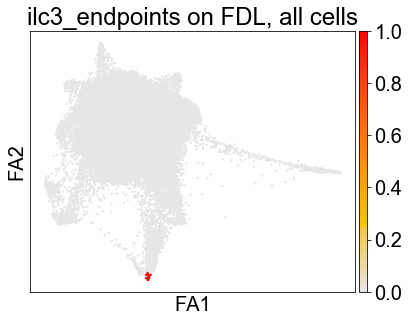

In [19]:
sel = adata.obs['day'] == '4'
ilc3_idx = select_by_dc_restricted(adata, 2, sel = sel, pick_high = False, name = 'ilc3_endpoints', components = '2,3',
                          pick_elems = pick_elems)

#### Quiescent

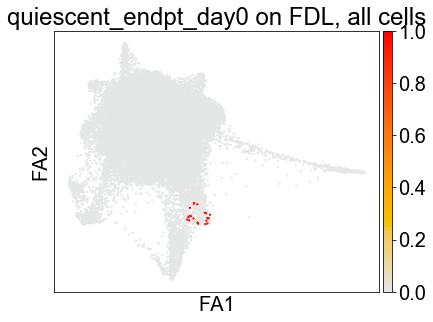

In [20]:
sel = adata.obs['day'] == '0'
quiescent_idx_day0 = select_by_dc_restricted(adata, 4, sel = sel, pick_high = True, name = 'quiescent_endpt_day0', components = '2, 4',
                            pick_elems = pick_elems)

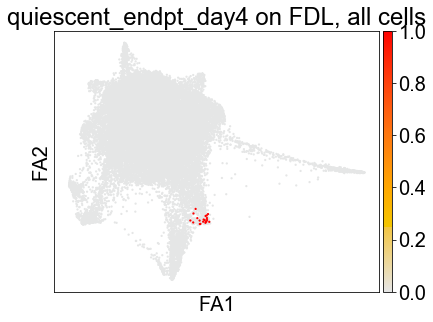

In [21]:
sel = adata.obs['day'] == '4'
quiescent_idx_day4 = select_by_dc_restricted(adata, 4, sel = sel, pick_high = True, name = 'quiescent_endpt_day4', components = '2, 4',
                            pick_elems = pick_elems)

#### ILC2

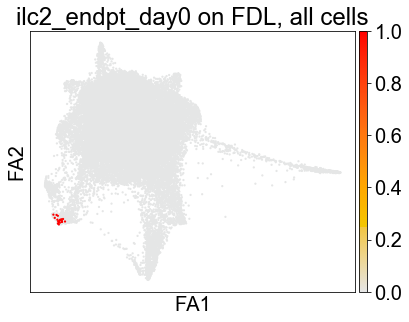

In [22]:
sel = adata.obs['day'] == '0'
ilc2_idx_day0 = select_by_dc_restricted(adata, 3, sel = sel, pick_high = False, name = 'ilc2_endpt_day0', components = '2, 3',
                       pick_elems = pick_elems)

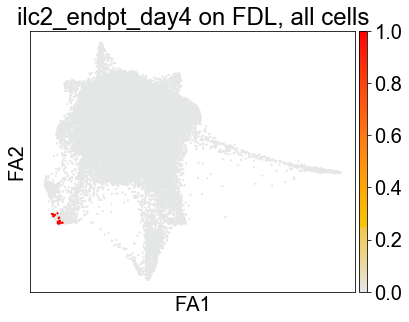

In [23]:
sel = adata.obs['day'] == '4'
ilc2_idx_day4 = select_by_dc_restricted(adata, 3, sel = sel, pick_high = False, name = 'ilc2_endpt_day4', components = '2, 3',
                       pick_elems = pick_elems)

#### Cloud

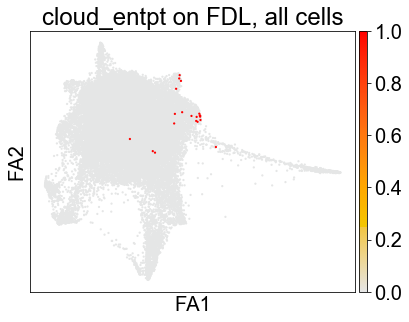

In [24]:
sel = (adata.obs['lda_3'] < 0.02) & (adata.obs['lda_1'] < 0.02) & \
    (adata.obs['lda_2'] < 0.02) & (adata.obs['day'] == '0')
cloud_idx = select_by_dc_restricted(adata, 2, sel, pick_high = False, name = 'cloud_entpt', components = '2, 3',
                       pick_elems = pick_elems, plot = True)

#### Additional start/end point plots

In [25]:
def start_endpoint_figures(adata, start_idx, end_idx, start_dc, end_dc, title,
                           pointsize = 8):
    
    cm = matplotlib.cm.get_cmap('cool')
    fig, ax = plt.subplots(figsize = (6.4, 4.8))
    sc.pl.draw_graph(adata, ax = ax, show = False)
    ax.scatter(*adata[start_idx,:].obsm['X_draw_graph_fa'].T, c = [cm(0)], s = pointsize, label = 'Startpoints')
    ax.scatter(*adata[end_idx,:].obsm['X_draw_graph_fa'].T, c = [cm(255)], s = pointsize, label = 'Endpoints')
    ax.set_title(title)
    ax.legend(loc = 'lower right')

    fig, ax = plt.subplots(figsize = (6.4, 4.8))
    sc.pl.diffmap(adata, ax = ax, components = [f"{start_dc},{end_dc}"], show = False)
    coords = adata.obsm['X_diffmap'][:,[start_dc, end_dc]]
    ax.scatter(*coords[start_idx,:].T, c = [cm(0)], s = pointsize, label = 'Startpoints')
    ax.scatter(*coords[end_idx,:].T, c = [cm(255)], s = pointsize, label = 'Endpoints')
    ax.set_title(title)
    ax.legend()

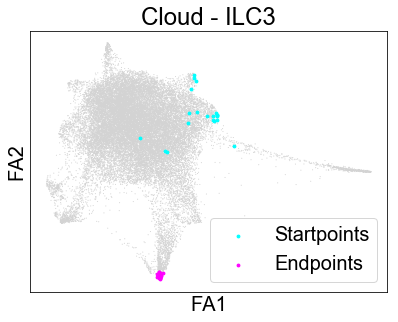

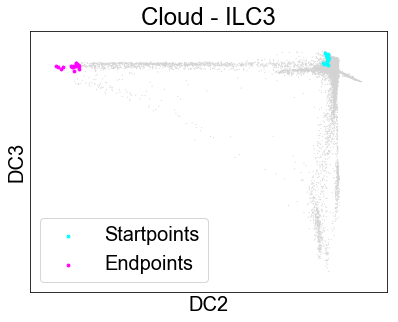

In [26]:
start_endpoint_figures(adata, cloud_idx, ilc3_idx, 2, 3, title = 'Cloud - ILC3')

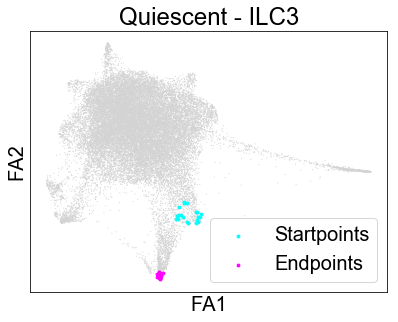

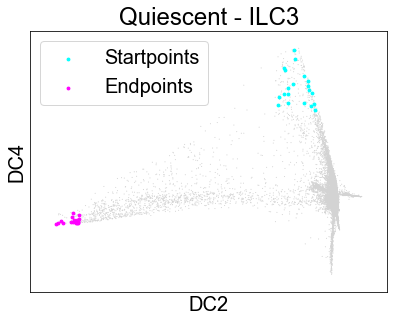

In [27]:
start_endpoint_figures(adata, quiescent_idx_day0, ilc3_idx, 2, 4, title = 'Quiescent - ILC3')

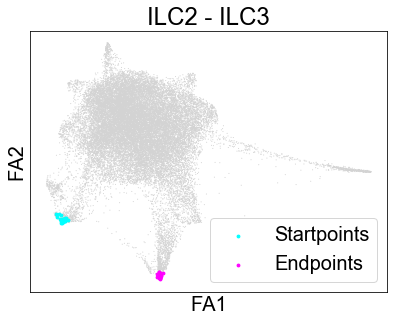

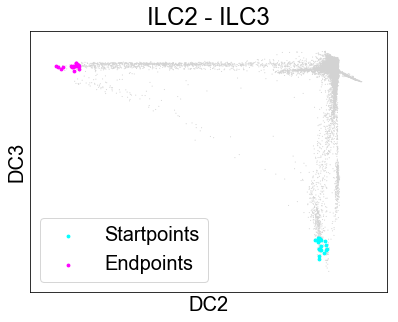

In [28]:
start_endpoint_figures(adata, ilc2_idx_day0, ilc3_idx, 2, 3, title = 'ILC2 - ILC3')

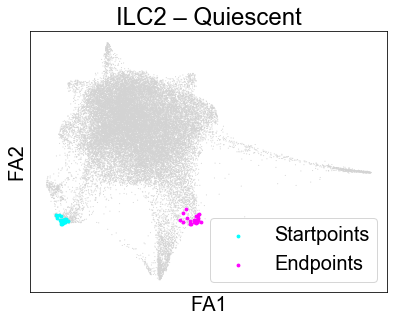

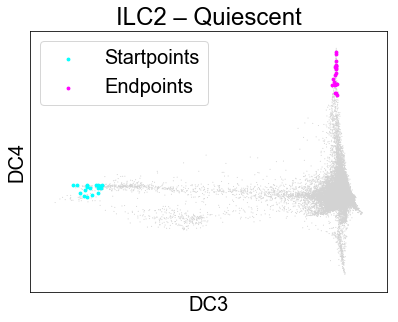

In [29]:
start_endpoint_figures(adata, ilc2_idx_day0, quiescent_idx_day4, 3, 4, title = 'ILC2 – Quiescent')

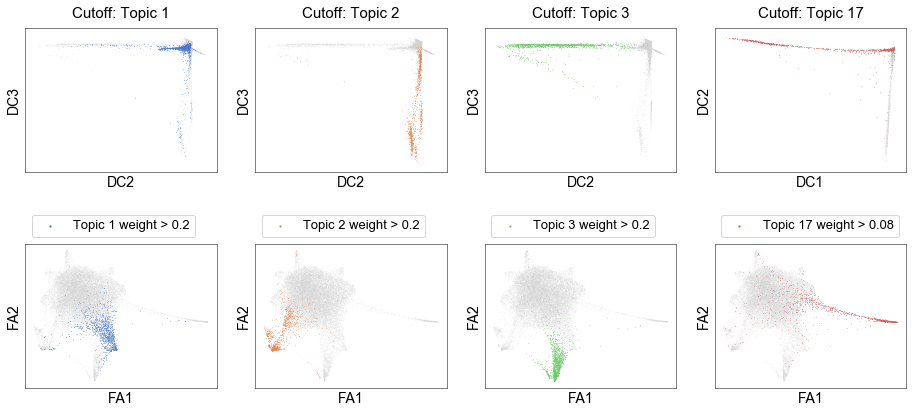

In [30]:
plot_data = [
    {"title" : "Cutoff: Topic 1", "topic" : "lda_1", "cutoff" : 0.2, "components" : [2, 3]},
    {"title" : "Cutoff: Topic 2", "topic" : "lda_2", "cutoff" : 0.2, "components" : [2, 3]},
    {"title" : "Cutoff: Topic 3", "topic" : "lda_3", "cutoff" : 0.2, "components" : [2, 3]},
    {"title" : "Cutoff: Topic 17", "topic" : "lda_17", "cutoff" : 0.08, "components" : [1, 2]}
]
size = .5
highlight_size = 1
label_fontsize = 14
right = 0.95
linewidth = 0.5
fig, axes = subplots_fixed_width(2, len(plot_data), figsize = (2.66, 2), left = 0.05, right = 0.95, top = 0.9,
                                 bottom = 0.1, hspace = 0.5)


for i, (data, axes_col, color) in enumerate(zip(plot_data, axes.T, sns.palettes.color_palette('muted'))):
    for j, ax in enumerate(axes_col):
        sel = adata.obs[data["topic"]] > data["cutoff"]
        if j == 0:
            sc.pl.diffmap(adata, components = ",".join(map(str, data["components"])), ax = ax, show = False, size = size)
            coords = adata.obsm['X_diffmap'][:,data["components"]]
            ax.scatter(*coords[sel, :].T, c = [color], s = highlight_size, marker = '.', linewidths = 0,
                      label = "Topic {} weight > {}".format(data['topic'][4:], data['cutoff']))
            ax.set_title(data["title"], pad = 10, fontsize = label_fontsize + 1)
            legend = ax.legend(fontsize = label_fontsize - 1, loc = "lower left",
                              bbox_to_anchor = [0.0, -0.5])
            for handle in legend.legendHandles:
                handle.set_sizes([20.0])
        if j == 1:
            sc.pl.draw_graph(adata, ax = ax, show = False, size = size)
            coords = adata.obsm['X_draw_graph_fa']
            ax.scatter(*coords[sel, :].T, c = [color], s = highlight_size, marker = '.', linewidths = 0)
            
        plt.setp([ax.yaxis.label, ax.xaxis.label], fontsize = label_fontsize)
        plt.setp(ax.spines.values(), linewidth = linewidth)
        

### Calculate and plot trajectories

#### Helper functions for cutoffs

In [31]:
def quantile_fit(x_raw, y_raw, tau, degfreedom, plot = False,
                 low_cutoff = 0.00, high_cutoff = 1.00,
                 global_cutoff = 0.98, do_legend = False,
                 title = None):
    """
    Perform non-parametric quantile regression via R.
    """
    
    importr('splines')
    importr('quantreg')
    
    notnan_sel = ~np.isnan(x_raw)
    x_notnan = x_raw[notnan_sel]
    inside_sel = (x_notnan > low_cutoff) & (x_notnan < high_cutoff)
    outside_sel = (x_notnan <= low_cutoff) | (x_notnan >= high_cutoff)
    sel_idx = np.argwhere(notnan_sel)[inside_sel].flatten()
    
    x = x_raw[sel_idx]
    y = y_raw[sel_idx]
    
    perc = np.percentile(y, global_cutoff * 100)
    
    ind = np.argsort(x)
    x = x[ind]
    y = y[ind]
    data = pd.DataFrame({'x' : x, 'y' : y})
    
    f = robjects.r['rq'](robjects.Formula('y ~ bs(x, df = {:d})'.format(degfreedom)), data, tau = tau)
    y_pred = f.rx('fitted.values')[0]
    
    x_additional = x_raw[notnan_sel][outside_sel]
    y_additional = y_raw[notnan_sel][outside_sel]
    keep_sel = (y > y_pred) | (y > perc)
    discard_sel = ~keep_sel
    
    if False:
        print(x_raw.shape, y_raw.shape)
        plt.plot(x_raw[~np.isnan(x_raw)], y_raw[~np.isnan(x_raw)], 'x')
    if plot:
        label_fontsize = 7
        size = 3
        lw = 1.0
        right_overhang = 0.1
        spine_width = 0.5
        
        (fig, ax) = plt.subplots(figsize = (2, 1.7), dpi = 200)
        ax.axvline(0, label = 'Start/end point', linewidth = lw/2, color = 'gray', linestyle = '--')
        ax.axvline(1, linewidth = lw/2, color = 'gray', linestyle = '--')
        ax.plot(x[discard_sel], y[discard_sel], '.', color = 'blue', label = 'Discarded', linewidth = 0,
                markersize = size, lw = 0, markeredgewidth = 0)
        ax.plot(np.hstack([x[keep_sel], x_additional]), np.hstack([y[keep_sel], y_additional]), '.', color = 'orange',
               label = 'Kept',
                markersize = size,
               lw = 0, markeredgewidth = 0)
        ax.axhline(perc, color = 'maroon', label = f'Overall quantile,\nq = {global_cutoff:.2f}',
                  linewidth = lw)
        ax.plot(x, y_pred, '-', color = 'red', label = f'Quantile regression,\nq = {tau:.2f}', linewidth = lw)
        
        if do_legend:
            legend = ax.legend(fontsize = label_fontsize - 2, bbox_to_anchor = (1, 1), markerscale = 2,
                          loc = "upper left")
        else:            
            custom_lines = [lines.Line2D([0,0.001], [0,0], color="maroon", lw=2),
                            lines.Line2D([0,0.001], [0,0], color="red", lw=2)]
            ax.legend(custom_lines, (f'q = {global_cutoff:.2f}', f'q = {tau:.2f}'), fontsize = label_fontsize - 2, handlelength = 1,
                     loc = "upper left")
        ax.set_xlabel("Estimated position of cell", fontsize = label_fontsize)
        ax.set_ylabel("Proportion of paths containing cell", fontsize = label_fontsize)
        ax.set_title(f"{title}, cutoff", fontsize = label_fontsize + 1)
        ax.tick_params(labelsize = label_fontsize)
        plt.setp(ax.spines.values(), linewidth = spine_width)
        plt.setp(ax.yaxis.get_ticklines() + ax.xaxis.get_ticklines(), markeredgewidth = spine_width)
        
        ax.grid('off')
        
        plt.subplots_adjust(top = 0.9, bottom = 0.2)
    
    keep_sel_global = np.full(x_raw.shape, False)
    revind = np.argsort(ind)
    keep_sel_global[sel_idx] = (y[revind] > y_pred[revind]) | (y[revind] > perc)
    keep_sel_global[notnan_sel] |= outside_sel
    
    return keep_sel_global

In [32]:
def save_trajectory(adata, name, freqs, pos,
                    quantile = 0.95,
                    multiplier = 1.0, knots = 30, plot = True, title = None,
                    global_cutoff = 0.98, do_legend = True,
                    show_prolif = False,
                    **kwargs):
    """
    Save and plot the trajectory.
    """
    
    keep_sel = quantile_fit(pos, freqs, tau = quantile, degfreedom = knots, plot = plot,
                                 title = title, global_cutoff = global_cutoff,
                                 do_legend = do_legend)
    
    adata.obs[name] = np.nan
    adata.obs.loc[adata.obs.index[keep_sel],name] = pos[keep_sel]
    
    if plot:
        if not show_prolif:
            sel = adata.obs['lda_17'] <= 0.08
        else:
            sel = np.full(adata.shape[0], True)
        old_figsize = matplotlib.rcParams['figure.figsize']
        matplotlib.rcParams['figure.figsize'] = (4,4)
        
        fig = sc.pl.draw_graph(adata[sel, :], return_fig = True)
        ax = sc.pl.draw_graph(adata[sel, :], color = name, cmap = 'cool', ax = fig.axes[0],
                              title = title,
                              **kwargs, show = False)
        ax.title.set(fontsize = 18)
        ax.xaxis.label.set(fontsize = 14)
        ax.yaxis.label.set(fontsize = 14)
        colorbar = ax.collections[1].colorbar
        colorbar.set_label('Pseudotime', labelpad = 10, fontsize = 16)
        colorbar.ax.tick_params(labelsize = 14)

        matplotlib.rcParams['figure.figsize'] = old_figsize
        return fig

In [33]:
def plot_selected_by_day(adata, column, sel):
    """
    Plot the selected cells by day.
    """
    
    fig, axes = plt.subplots(1, 5, figsize = (4*5.5,4))
    adata_cut = adata[sel]

    for day, ax in zip(adata.obs['day'].unique(), axes):
        sc.pl.draw_graph(adata_cut, show = False, ax = ax)
        sc.pl.draw_graph(adata_cut[~(adata_cut.obs[column].isna()) & (adata_cut.obs['day'] == day)], color = 'day', cmap = 'cool', ax = ax, s = 50, show = False,
                        title = f'Day {day}', palette = [day_palette[int(day)]])
        ax.get_legend().remove()

#### Heatmap plotting functions

In [34]:
def heatmap_plot(adata, time_field, fields, double_fields = [], plot = True,
                 cmap = 'inferno', cmap_double = cm_black_white_discrete,
                 top_cap = 4, fontsize = 20, cbar_ticks = None,
                 cbar_label = 'Expression'):
    """
    Plotting routine for the heatmaps
    """
    
    # Convenience for single field
    if isinstance(fields, str):
        fields = [fields]
    
    # Temporarily overwrite font size
    old_fontsize = matplotlib.rcParams['font.size']
    matplotlib.rcParams['font.size'] = fontsize
    
    path = adata[~np.isnan(adata.obs[time_field]), :]
    
    non_obs_fields = []
    obs_fields = []
    for f in fields:
        if not f in adata.obs.columns:
            if f in adata.var.index:
                non_obs_fields.append(f)
            else:
                raise Exception("fields need to be either in adata.obs.columns or adata.var.index")
        else:
            obs_fields.append(f)
    
    plot_fields = fields
    df = path.obs.loc[:, obs_fields].copy()
    df[time_field] = path.obs[time_field]
            
    if len(non_obs_fields) > 0:
        mat = path[:, non_obs_fields].X
        mat = mat.toarray() if scipy.sparse.issparse(mat) else mat
        df = pd.concat([df, pd.DataFrame(mat, index = path.obs.index, columns = non_obs_fields)], axis = 1)
    
    df = df.reindex([time_field] + fields, axis = 1)
    df.sort_values(by = time_field, inplace = True)
    
    df = df.transpose()
    df.rename(index = {time_field : 'Pseudotime'}, inplace = True)
    
    if len(double_fields) > 0:
        df2 = path.obs.loc[:, double_fields].copy()
        df2[time_field] = path.obs[time_field]
        df2 = df2.reindex([time_field] + double_fields, axis = 1)
        df2.sort_values(by = time_field, inplace = True)
        df2 = df2.transpose()
        df2.rename(index = {time_field : 'Pseudotime'}, inplace = True)
    
    if plot:
        f = plt.figure(figsize = (12, (len(fields) + len(double_fields) + 1)*0.3), dpi = 400)
        if len(double_fields) > 0:
            gs_hspace = 0.05
            gs_inner_left = f.add_gridspec(3, 1, height_ratios = [0.7, df2.shape[0] - 1, df.shape[0] - 1],
                                               hspace = gs_hspace, wspace = 0)
        else:
            gs_hspace = 0.05
            gs_inner = f.add_gridspec(2, 1, height_ratios = [0.5, df.shape[0] - 1],
                                               hspace = gs_hspace, wspace = 0)
        if len(double_fields) > 0:
            ax_top = f.add_subplot(gs_inner_left[0])
            ax_bot1 = f.add_subplot(gs_inner_left[1])
            ax_bot2 = f.add_subplot(gs_inner_left[2])
            length_unit = (1 - 2*gs_hspace) / (0.7 + df2.shape[0] - 1 + df.shape[0] - 1)
            ax_cb_expr = f.add_axes([0.95, 0.0, 0.02, 6 * length_unit])
            ax_cb_double = f.add_axes([0.95, 6 * length_unit + gs_hspace, 0.025, 2 * length_unit])
        else:
            ax_top = f.add_subplot(gs_inner[0])
            ax_bot2 = f.add_subplot(gs_inner[1])
            length_unit = (1 - 2*gs_hspace) / (0.7 + df.shape[0] - 1)
            ax_cb_expr = f.add_axes([0.95, 0.0, 0.02, 6 * length_unit])
        f.subplots_adjust(bottom = 0, top = 1, left = 0, right = 0.9)
        
        hm = sns.heatmap(df.iloc[[0],:], xticklabels = False, ax = ax_top, cbar = False, cmap = 'cool',
                        linewidths = 0.0, rasterized = True, vmin = 0.0, vmax = 1.0)
        hm.xaxis.set_tick_params(labeltop = True, top = True, bottom = False, labelbottom = False, labelsize = 14)
        xticks = []
        for x in np.linspace(0.0, 0.8, 5):
            xticks.append(np.where(df.iloc[0, :].values >= x)[0][0])
        xticks.append(df.shape[1]-1)
        hm.set_xticks(xticks)
        hm.set_xticklabels([f'{x:.1f}' for x in np.linspace(0, 1, 6)])
        hm.axes.set_xlabel('')
        hm.set_yticklabels(hm.get_yticklabels(), rotation = 0)
        for _, spine in hm.spines.items():
            spine.set_visible(True)
        if False:
            colorbar = plt.colorbar(hm.collections[0], cax = ax_cb_pseudotime)
            colorbar.set_ticks([0, 0.5, 1])
            colorbar.set_ticklabels([0, 0.5, 1])
            colorbar.set_label('Pseudotime', labelpad = 10)
            colorbar.outline.set_linewidth(1)
        
        if len(double_fields) > 0:
            hm = sns.heatmap(df2.iloc[1:,:], xticklabels = False, ax = ax_bot1, cmap = cmap_double,
                             cbar = True,
                             cbar_ax = ax_cb_double, 
                             rasterized = True,
                             cbar_kws = {'ticks' : [0.0, 1.0],
                                         'shrink' : 0.5,
                                         'pad' : 0.2,
                                         'boundaries' : np.linspace(0, 1, 3)
                                        },
                             linewidths = 0
                            )
            for _, spine in hm.spines.items():
                spine.set_visible(True)
            hm.set_yticks(0.5 + np.arange(len(df2.index) - 1))
            hm.set_yticklabels(df2.index[1:], fontsize = fontsize, rotation = 0)
            hm.axes.set_xlabel('')
            colorbar = hm.collections[0].colorbar
            colorbar.set_ticks([0.25, 0.75])
            colorbar.set_ticklabels(['≤1 expressed', 'Both expressed'])
            colorbar.outline.set_linewidth(1)

        hm = sns.heatmap(df.iloc[1:,:], xticklabels = False, ax = ax_bot2, cbar_ax = ax_cb_expr, cmap = cmap,
                        norm = CappedNormalize(top = top_cap, clip = False),
                        rasterized = True,
                        linewidths = 0.0,
                        cbar_kws = {'ticks' : cbar_ticks},
                        )
        hm.axes.set_xlabel('')
        hm.set_yticklabels(hm.get_yticklabels(), rotation = 0)
        for _, spine in hm.spines.items():
            spine.set_visible(True)
        colorbar = hm.collections[0].colorbar
        colorbar.set_label(cbar_label, labelpad = 10)
        colorbar.outline.set_linewidth(1)
        
    # Restore old fontsize
    matplotlib.rcParams['font.size'] = old_fontsize
    
    return (df, hm)

Functions to save double gene expression

In [35]:
def double_gene_expression_col(adata, gene1, gene2):
    col_name = '{} and {}'.format(gene1, gene2)
    adata.obs[col_name] = ((adata[:, gene1].X > 0) & (adata[:, gene2].X > 0)).astype(np.float).flatten()
    return col_name
    
def double_gene_expression_col_list(adata, genes1, genes2):
    col_names = []
    for gene1 in genes1:
        for gene2 in genes2:
            col_name = double_gene_expression_col(adata, gene1, gene2)
            col_names.append(col_name)
    return col_names

Prepare directory to save results in.

In [36]:
trajectory_dir = os.path.join(data_dir, 'trajectory_inference')
os.makedirs(trajectory_dir, exist_ok = True)
non_prolif_sel = adata.obs['lda_17'] <= 0.08
heatmap_fontsize = 14
heatmap_cmap = cm_purple
heatmap_cmap_double = cm_black_white_discrete

#### Quiescent – ILC3

In [37]:
n_dcs = 10
pointsize = 15
path_type = 'quiescent_ilc3'

Calculate initial pseudotime.

In [38]:
pseudotime = average_pseudotime(adata, ilc3_idx, n_dcs = n_dcs)

Build the weighted transition matrix for directed diffusion.

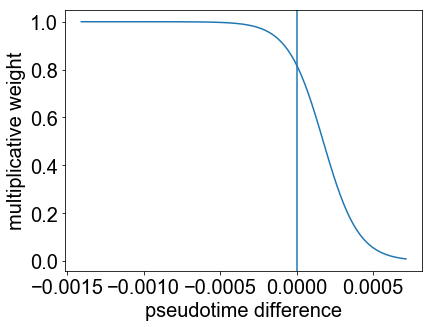

In [39]:
log_params = determine_logistic_params(pseudotime, steps_forward, steps_backward)
transitions = build_weighted_transition_matrix(T, pseudotime, variant = 'logistic', logistic_params = log_params)

Simulate random walks

In [40]:
transition_fname = os.path.join(trajectory_dir, 'quiescent_induced.bin')
(freqs_quiescent_ilc3, pos_quiescent_ilc3, rel_changes) = \
    run_walks_cached(transitions, quiescent_idx_day0, ilc3_idx, 25000,
                     fname = transition_fname, reset = reset_transitions)

Determine cut-offs on the visited cells.

/data/Development/Work/PsoriasisILC/pso_ilc_conda_test/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/data/Development/Work/PsoriasisILC/pso_ilc_conda_test/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


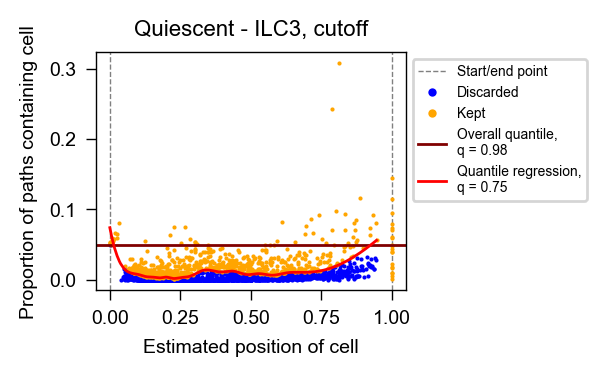

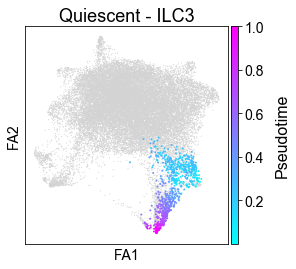

In [41]:
fig = save_trajectory(adata, path_type, freqs_quiescent_ilc3, pos_quiescent_ilc3,
                knots = 20, s = pointsize, quantile = 0.75, multiplier = 1.0,
                title = 'Quiescent - ILC3', global_cutoff = 0.98, plot = True)

Plot selected cells by day.

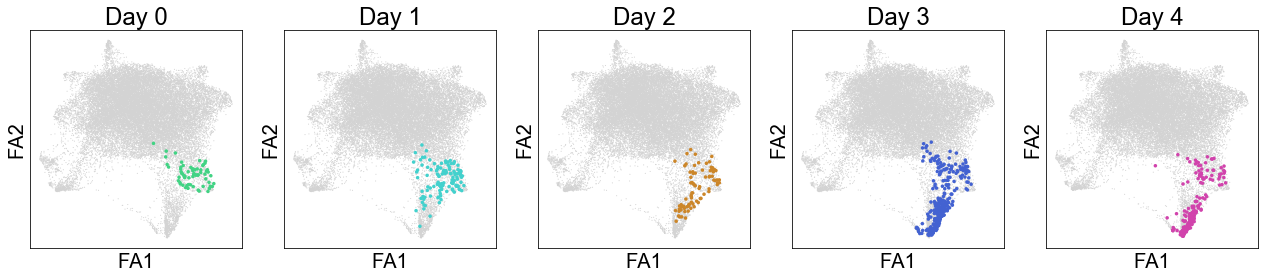

In [42]:
plot_selected_by_day(adata, path_type, non_prolif_sel)

Check number of cells in path

In [43]:
np.sum(~np.isnan(adata.obs[path_type]))

718

Plot the heatmap.

First, add fields containing double expression.

In [44]:
quiescent_fields = ['Tsc22d3', 'Zfp36', 'Klf4', 'Klf2', 'Fos']
ilc3_fields = ['Il23r', 'Rorc', 'Gzmb', 'Il22', 'Il17a']

In [45]:
double_gene_expression_col_list(adata_full, quiescent_fields, ilc3_fields)
adata_full.obs[path_type] = adata.obs[path_type]

/data/Development/Work/PsoriasisILC/pso_ilc_conda_test/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


In [46]:
quiescent_ilc3_fields = ['Il13'] + quiescent_fields + ['Hspa1a', 'Hspa1b', 'Jun', 'Egr1'] + ilc3_fields 
quiescent_ilc3_fields_double = ['Klf2 and Gzmb', 'Tsc22d3 and Il22']

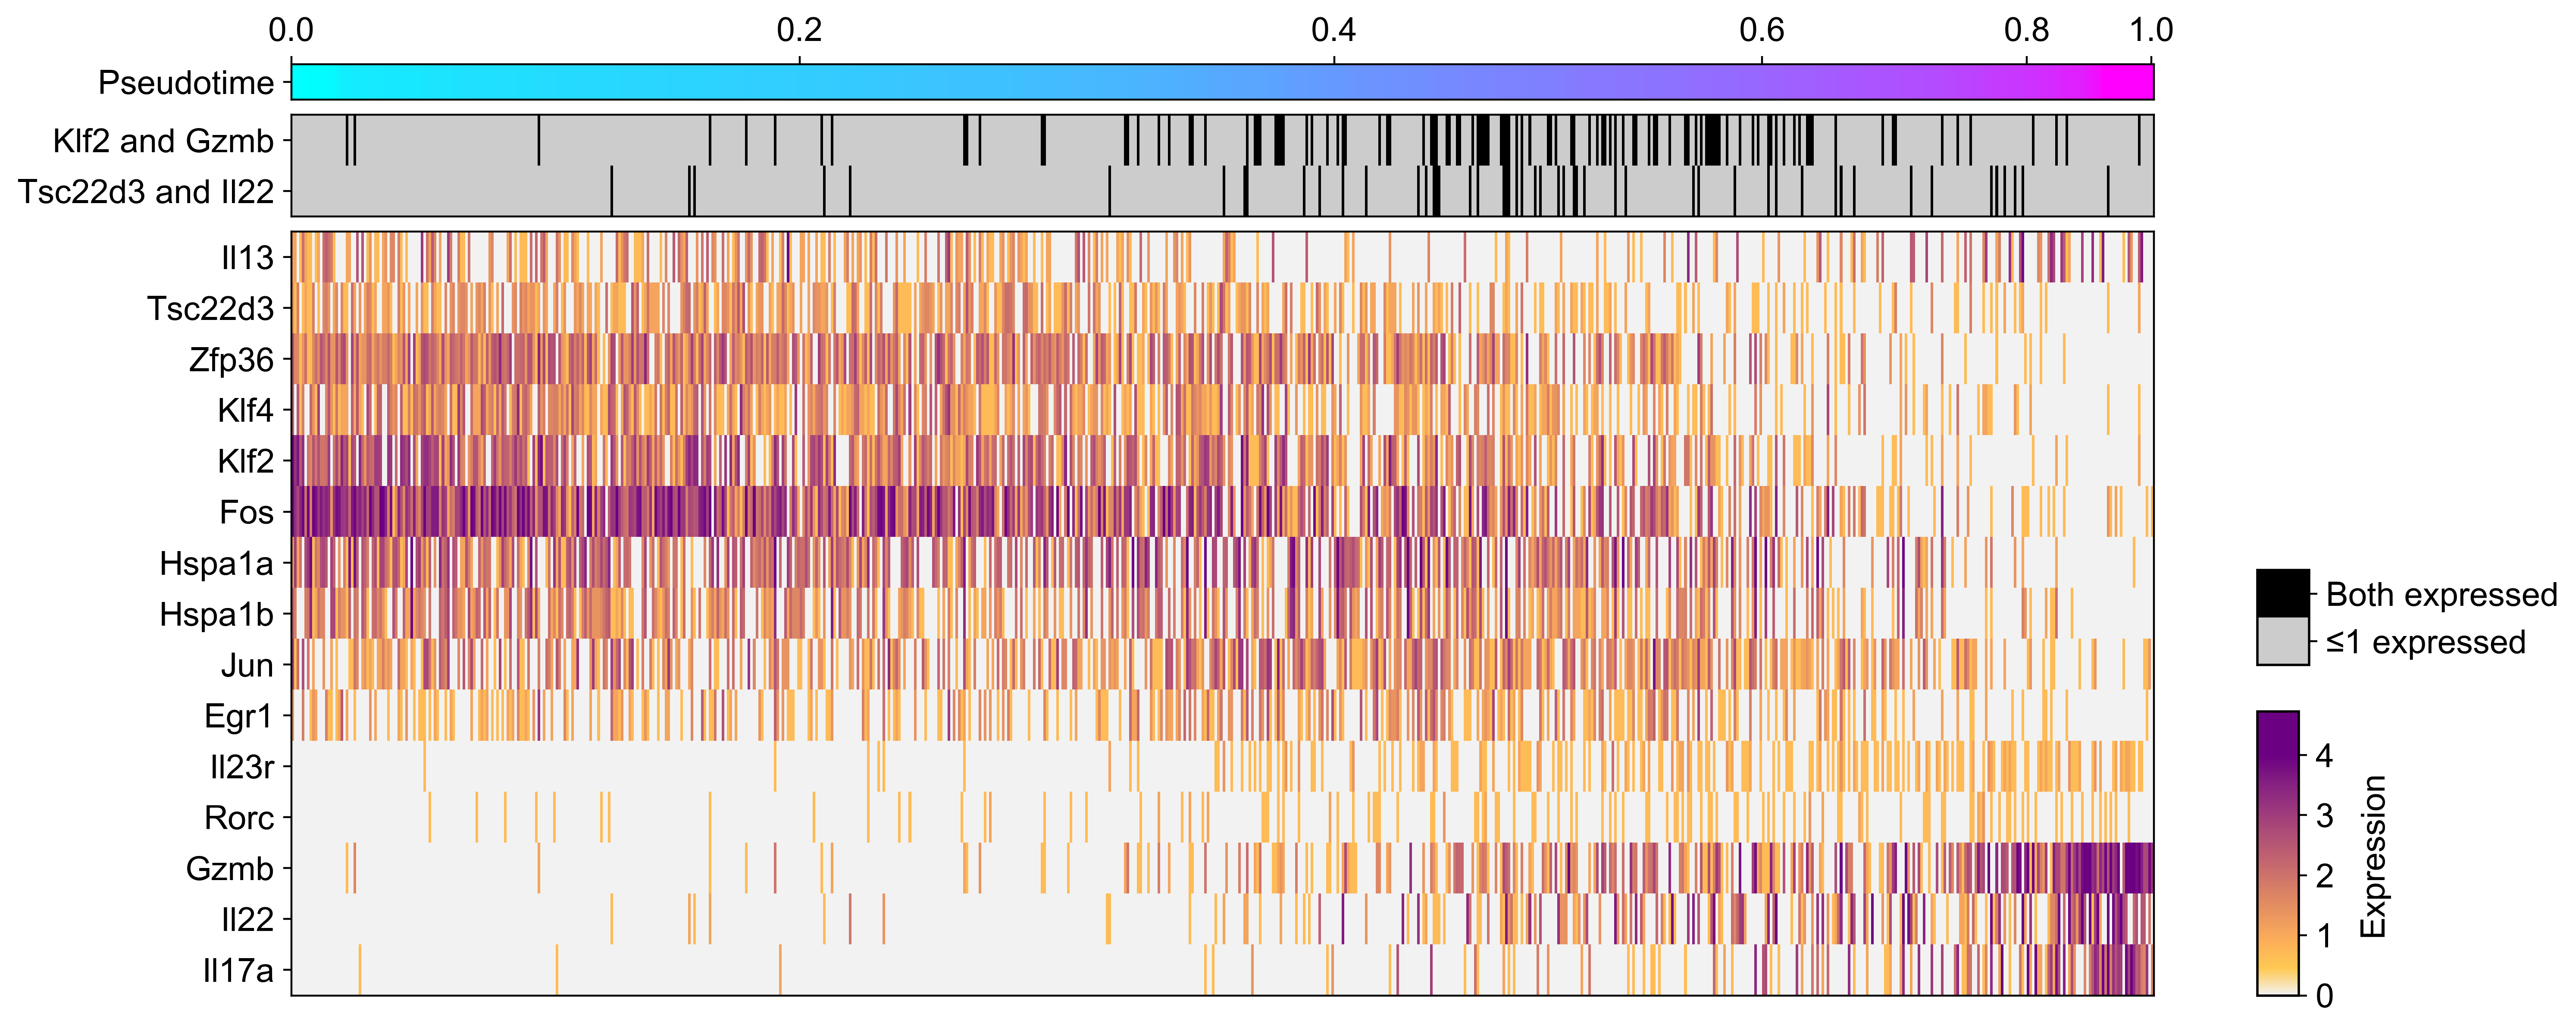

In [47]:
(df, hm) = heatmap_plot(adata_full, path_type,
                        quiescent_ilc3_fields, quiescent_ilc3_fields_double,
                        cmap = heatmap_cmap, cmap_double = heatmap_cmap_double,
                        fontsize = heatmap_fontsize, top_cap = 4)

#### Cloud – ILC3

In [48]:
path_type = 'cloud_ilc3'

In [49]:
pseudotime = average_pseudotime(adata, ilc3_idx, n_dcs = n_dcs)

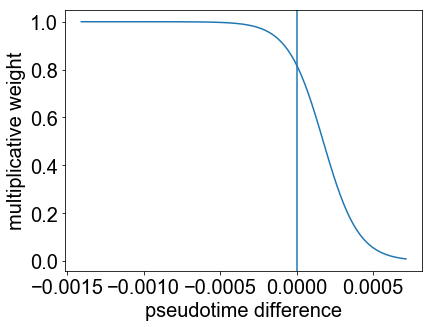

In [50]:
log_params = determine_logistic_params(pseudotime, steps_forward, steps_backward)
transitions = build_weighted_transition_matrix(T, pseudotime, variant = 'logistic', logistic_params = log_params)

In [51]:
transition_fname = os.path.join(trajectory_dir, f'{path_type}.bin')
(freqs_cloud_ilc3, pos_cloud_ilc3, rel_changes) = \
    run_walks_cached(transitions, cloud_idx, ilc3_idx, 50000,
                     fname = transition_fname, reset = reset_transitions)

In [52]:
np.min(rel_changes)

0.032051728030290993

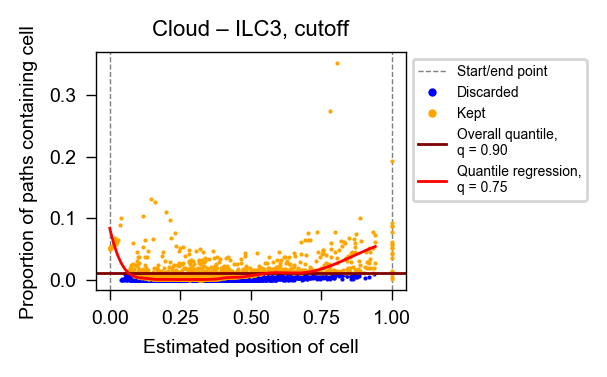

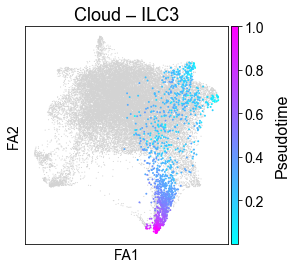

In [53]:
fig = save_trajectory(adata, path_type, freqs_cloud_ilc3, pos_cloud_ilc3,
                knots = 20, s = pointsize, quantile = 0.75, multiplier = 1.0,
                     title = 'Cloud \u2013 ILC3', global_cutoff = 0.9)

In [54]:
np.sum(~np.isnan(adata.obs[path_type]))

1276

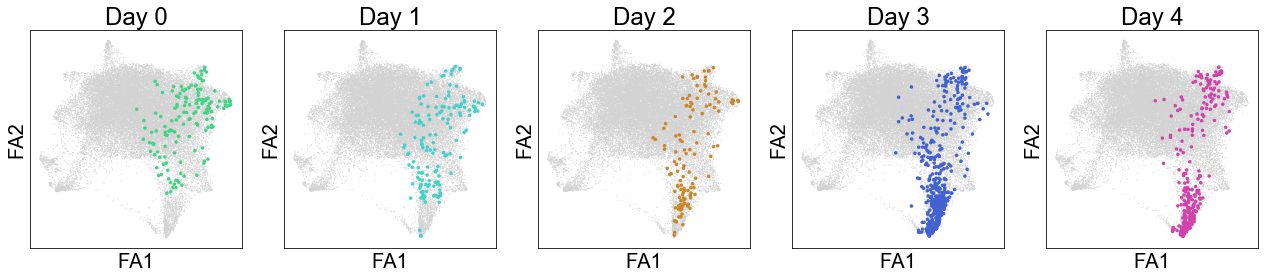

In [55]:
plot_selected_by_day(adata, path_type, non_prolif_sel)

In [56]:
cloud_fields = ['H2-Aa', 'Ccl5', 'Ms4a4b', 'Gata3', 'Rgs2', 'Hmgb2']
ilc3_fields = ['Lgals3', 'Gzmb', 'Rorc', 'Il23r', 'Il22', 'Il17a']
cloud_ilc3_fields = cloud_fields + ilc3_fields
cloud_ilc3_fields_double = ['Gata3 and Gzmb', 'Rgs2 and Il23r']

In [57]:
_ = double_gene_expression_col_list(adata_full, cloud_fields, ilc3_fields)

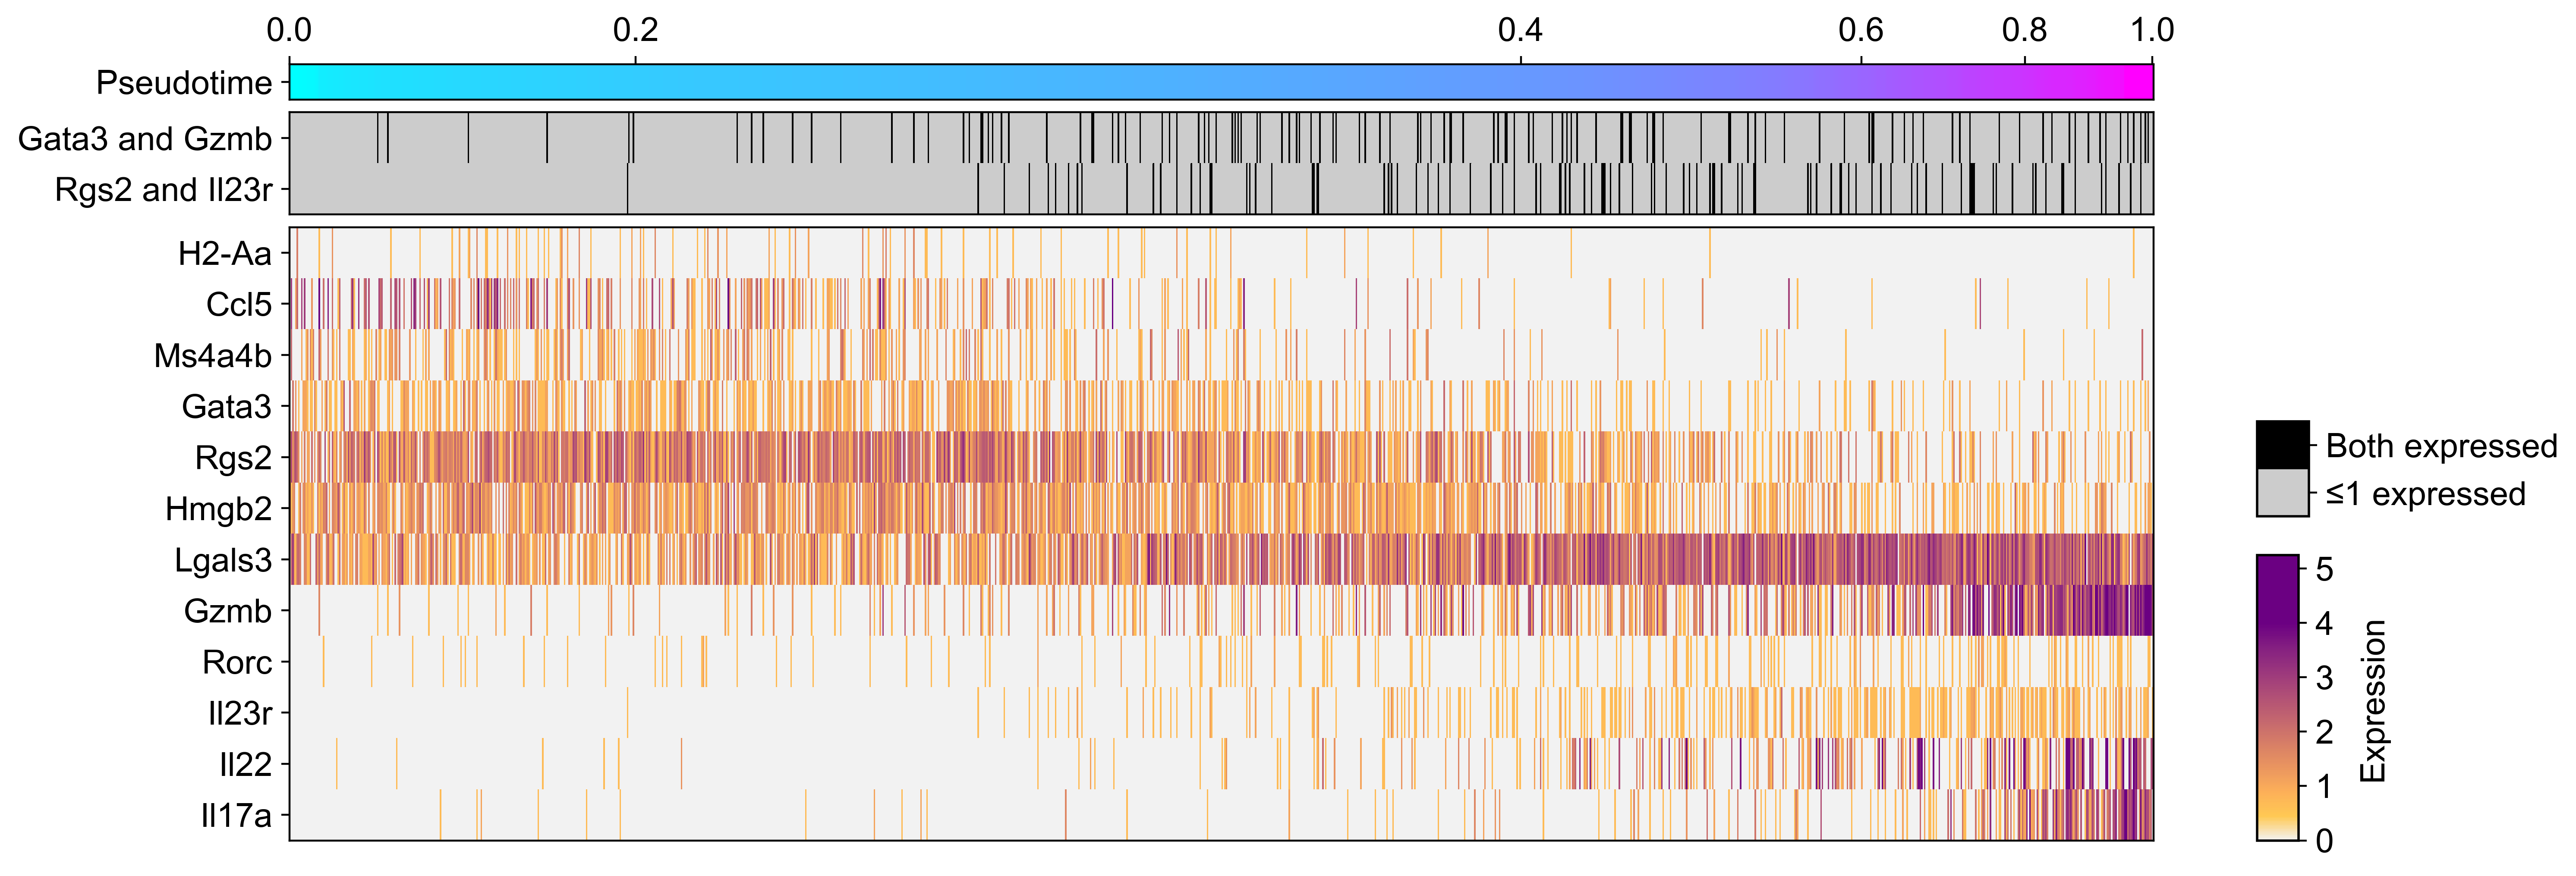

In [58]:
adata_full.obs[path_type] = adata.obs[path_type].copy()
_ = heatmap_plot(adata_full, path_type, cloud_ilc3_fields, cloud_ilc3_fields_double,
                 cmap = heatmap_cmap, cmap_double = heatmap_cmap_double,
                 fontsize = heatmap_fontsize)

#### ILC2 – Quiescent

In [59]:
path_type = 'ilc2_quiescent'

In [60]:
pseudotime = average_pseudotime(adata, quiescent_idx_day4, n_dcs = n_dcs)

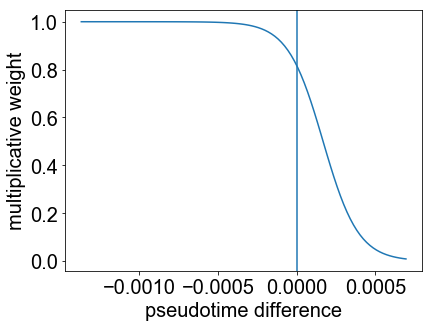

In [61]:
log_params = determine_logistic_params(pseudotime, steps_forward, steps_backward)
transitions = build_weighted_transition_matrix(T, pseudotime, variant = 'logistic', logistic_params = log_params)

In [62]:
transition_fname = os.path.join(trajectory_dir, f'{path_type}.bin')
(freqs_ilc2_quiescent, pos_ilc2_quiescent, rel_changes) = \
    run_walks_cached(transitions, ilc2_idx_day0, quiescent_idx_day4, 50000,
                     fname = transition_fname,
                     reset = reset_transitions)

In [63]:
np.min(rel_changes)

0.047846681113687256

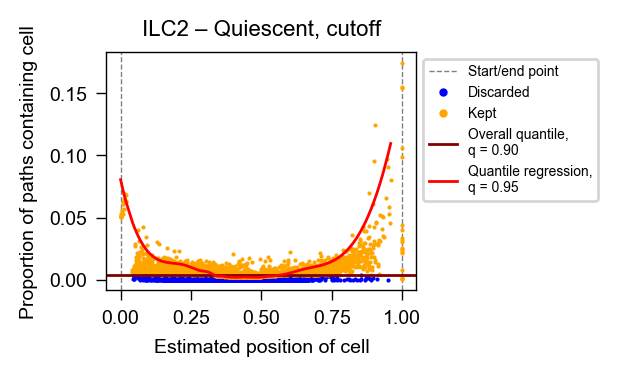

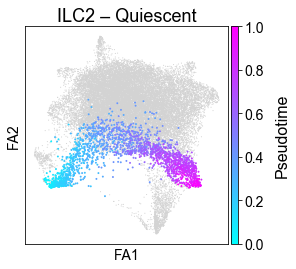

In [64]:
fig = save_trajectory(adata, path_type, freqs_ilc2_quiescent, pos_ilc2_quiescent,
                      knots = 20, s = pointsize, quantile = 0.95, multiplier = 1.0,
                      title = 'ILC2 \u2013 Quiescent', global_cutoff = 0.9,
                      do_legend = True)

In [65]:
np.sum(~np.isnan(adata.obs[path_type]))

1925

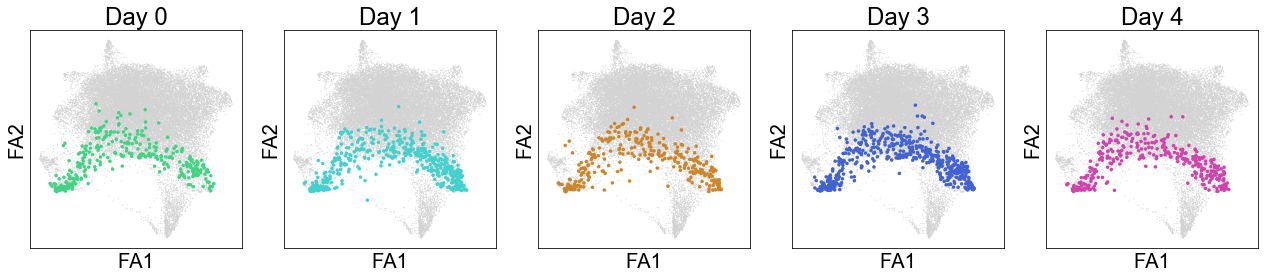

In [66]:
plot_selected_by_day(adata, path_type, non_prolif_sel)

In [67]:
ilc2_fields = ['Areg', 'Tnfsf9', 'Ramp3', 'Cxcl2', 'Cre (Il5)','Il1rl1',  'Ccl1']
quiescent_fields = ['Hspa1b', 'Hspa1a', 'Klf2', 'Jaml', 'Jun', 'Fos']
ilc2_quiescent_fields = quiescent_fields + ilc2_fields
ilc2_quiescent_fields = list(reversed(ilc2_quiescent_fields))
ilc2_quiescent_fields_double = ['Hspa1a and Cxcl2', 'Jaml and Tnfsf9']

In [68]:
double_gene_expression_col_list(adata_full, quiescent_fields, ilc2_fields)
adata_full.obs[path_type] = adata.obs[path_type]

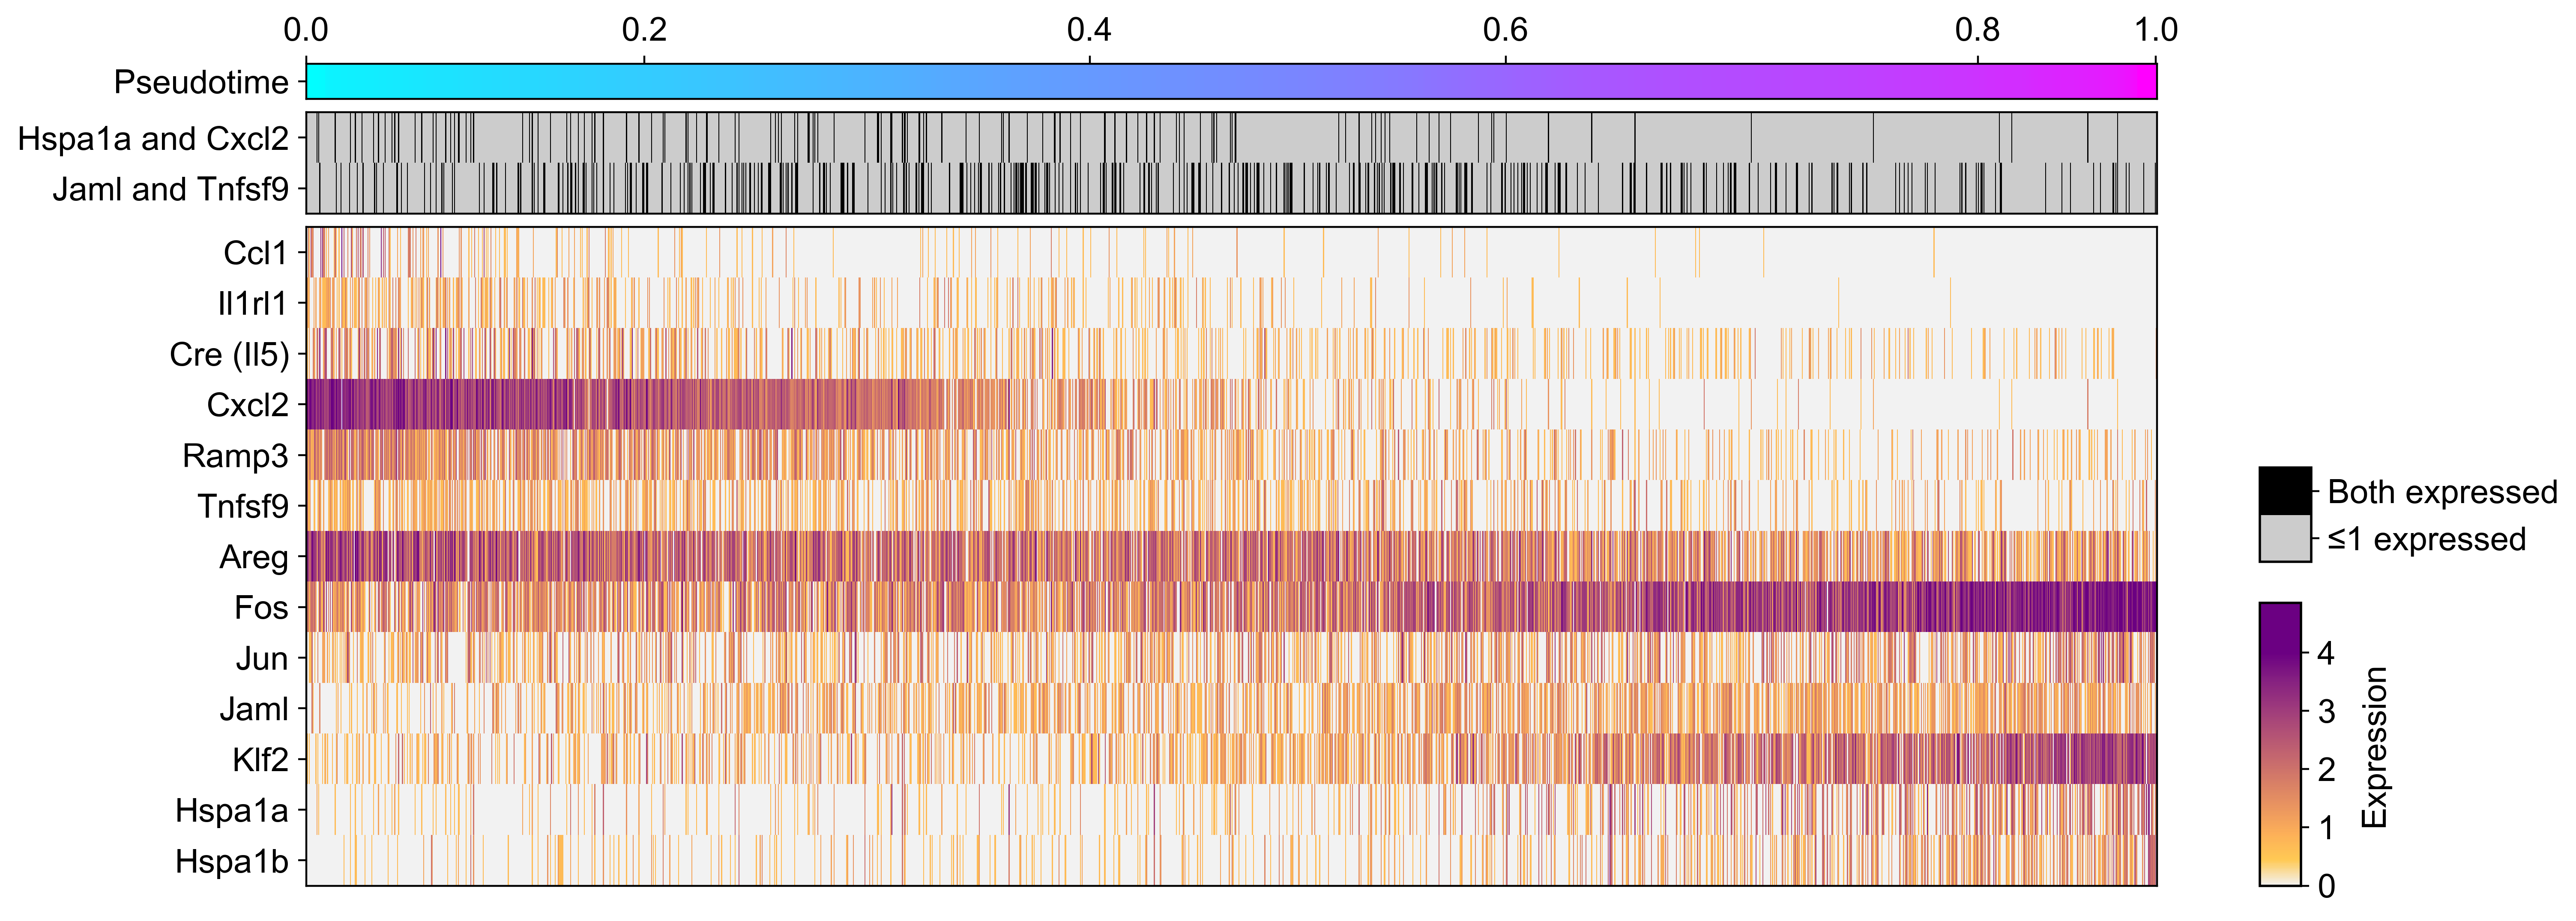

In [69]:
_ = heatmap_plot(adata_full, path_type,
                     ilc2_quiescent_fields, ilc2_quiescent_fields_double,
                     cmap_double = heatmap_cmap_double,
                     cmap = heatmap_cmap, fontsize = heatmap_fontsize,
                     cbar_ticks = np.arange(0,5), top_cap = 4)

### ILC2 – ILC3

In [70]:
path_type = 'ilc2_ilc3'

In [71]:
pseudotime = average_pseudotime(adata, ilc3_idx, n_dcs = n_dcs)

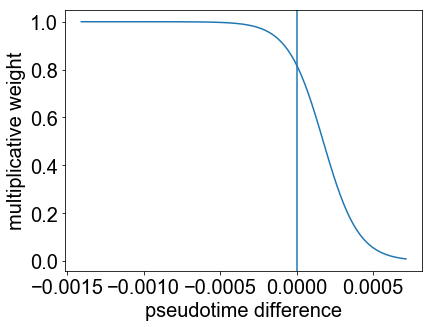

In [72]:
log_params = determine_logistic_params(pseudotime, steps_forward, steps_backward)
transitions = build_weighted_transition_matrix(T, pseudotime, variant = 'logistic', logistic_params = log_params)

In [73]:
transition_fname = os.path.join(trajectory_dir, f'{path_type}.bin')
(freqs_ilc2_ilc3, pos_ilc2_ilc3, rel_changes) = \
    run_walks_cached(transitions, ilc2_idx_day0, ilc3_idx, 100000,
                     fname = transition_fname, reset = reset_transitions)

In [74]:
np.min(rel_changes)

0.028554291172004847

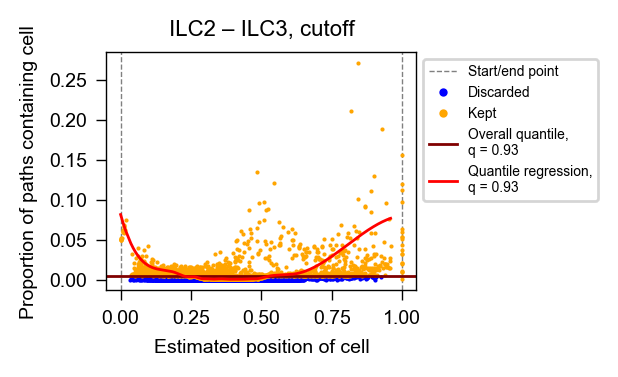

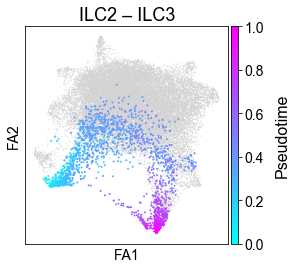

In [75]:
fig = save_trajectory(adata, path_type, freqs_ilc2_ilc3, pos_ilc2_ilc3,
                      knots = 20, s = pointsize, quantile = 0.925, multiplier = 1.0,
                      title = 'ILC2 \u2013 ILC3', global_cutoff = 0.925)

In [76]:
np.sum(~np.isnan(adata.obs[path_type]))

1797

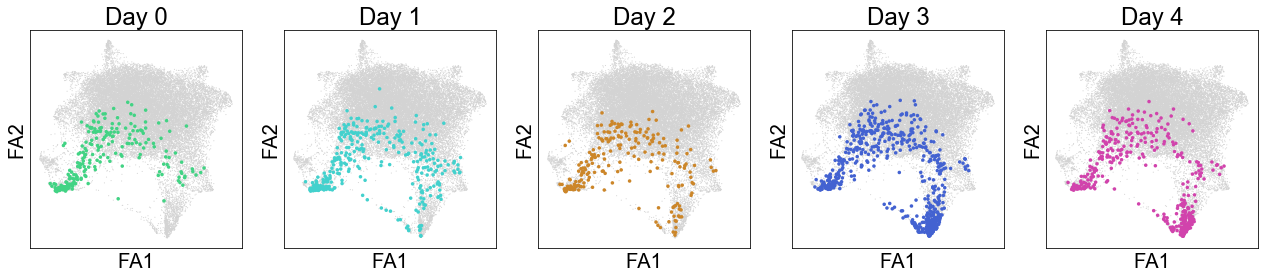

In [77]:
plot_selected_by_day(adata, path_type, non_prolif_sel)

In [78]:
ilc2_fields = ['Ccl1', 'Il1rl1', 'Cre (Il5)', 'Il13', 'Ramp3', 'Gata3']
ilc3_fields = ['Lgals3', 'Hspa1a', 'Hspa1b', 'Gzmb', 'Rorc', 'Il23r', 'Il17a', 'Il22']
ilc2_ilc3_fields = [] + ilc2_fields + ilc3_fields
ilc2_ilc3_fields_double = ['Ramp3 and Il23r', 'Cre (Il5) and Il22']

In [79]:
double_gene_expression_col_list(adata_full, ilc2_fields, ilc3_fields)
adata_full.obs[path_type] = adata.obs[path_type]

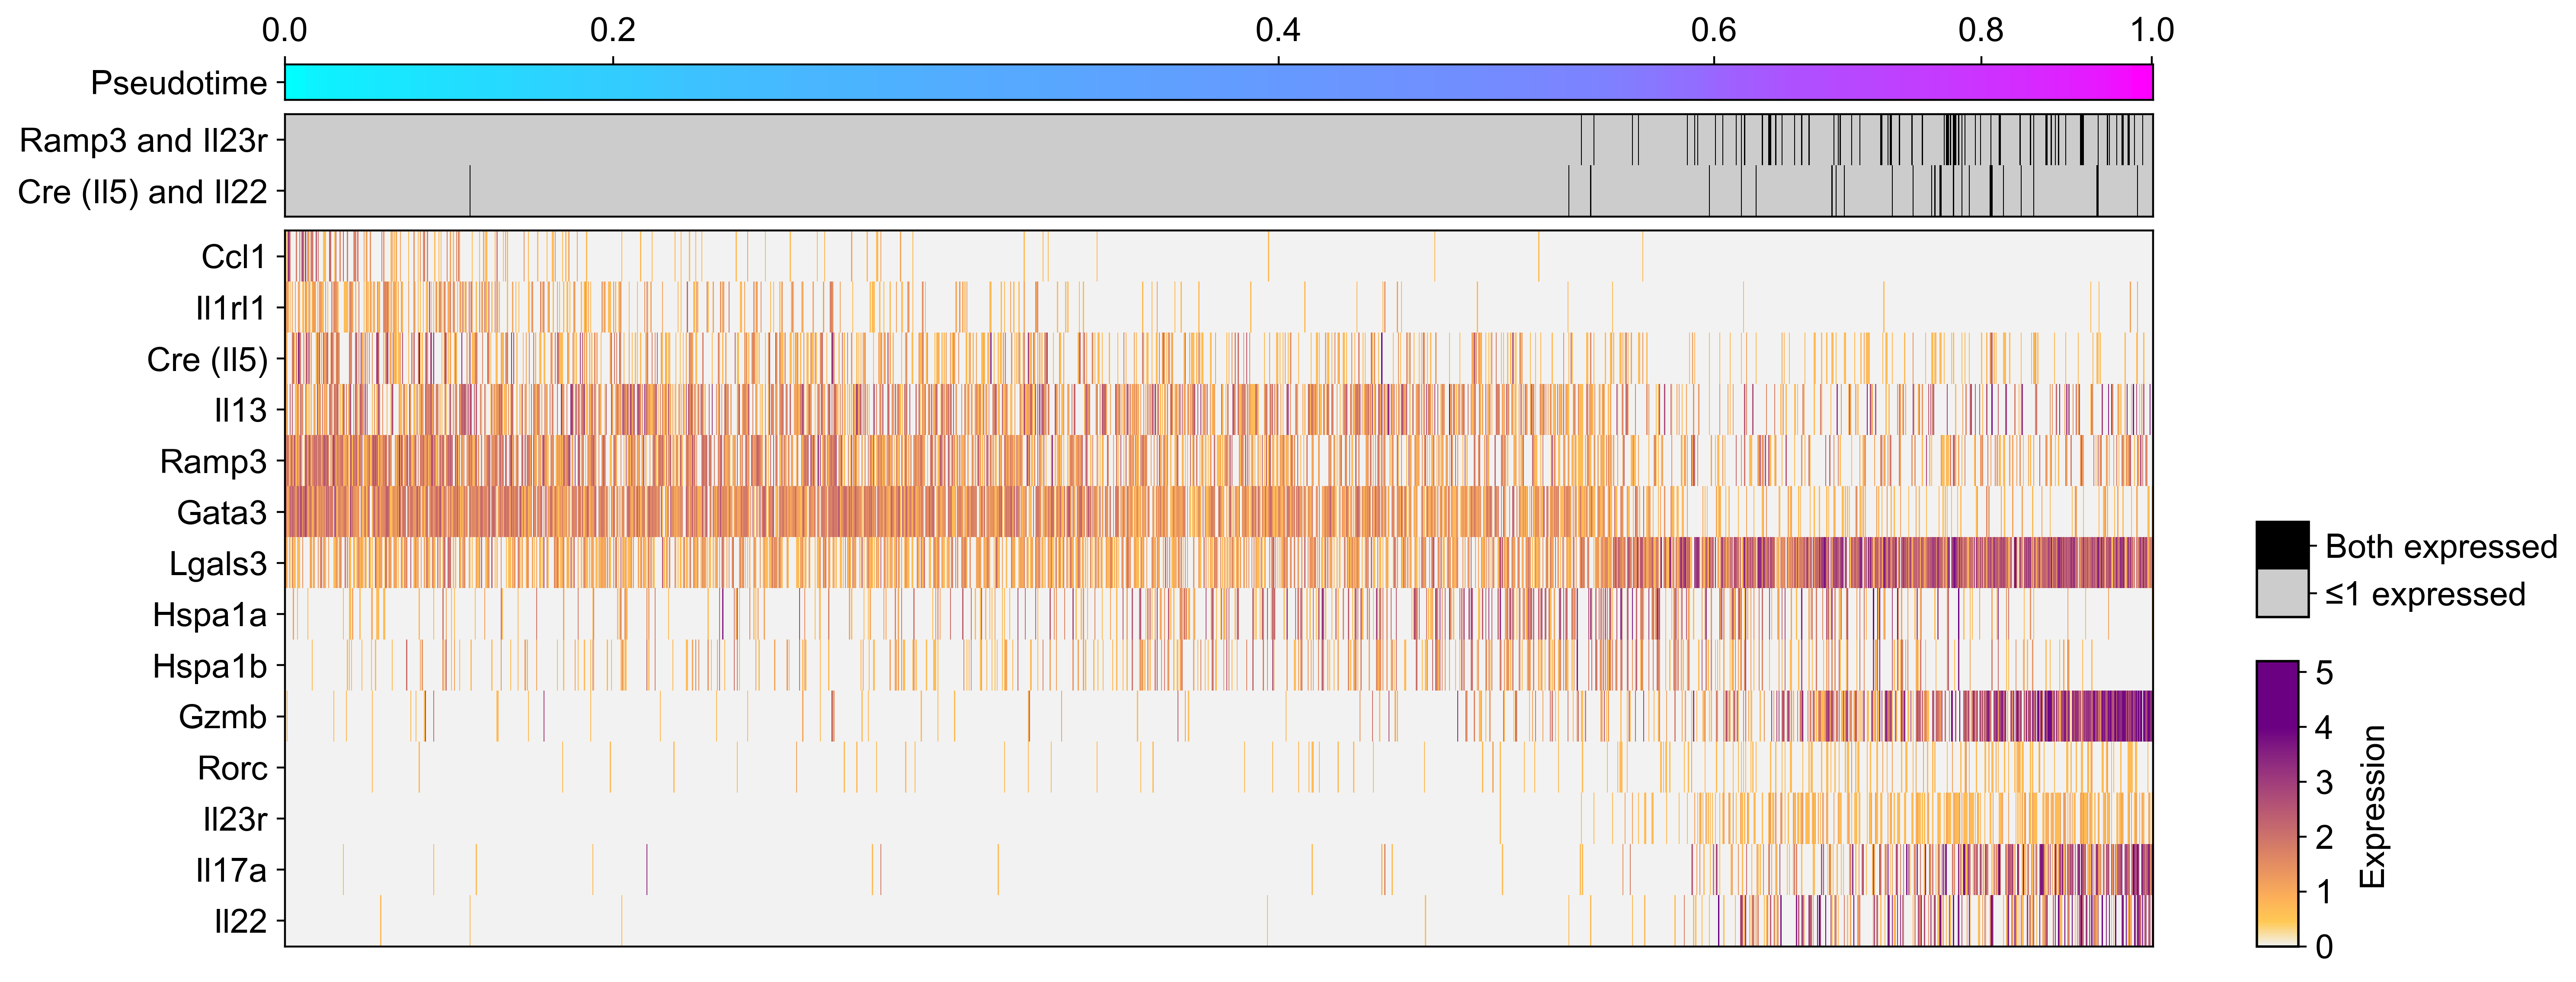

In [80]:
_ = heatmap_plot(adata_full, path_type, ilc2_ilc3_fields,
                 ilc2_ilc3_fields_double,
                 cmap_double = heatmap_cmap_double, cmap = heatmap_cmap, fontsize = heatmap_fontsize)

## Save with updated columns

Restrict to interesting columns

In [81]:
add_cols = ['cloud_entpt', 'dpt_pseudotime', 'ilc2_endpt_day0', 'ilc2_endpt_day4',
            'ilc3_endpoints', 'quiescent_endpt_day0', 'quiescent_endpt_day4']

In [82]:
adata_full.obs[add_cols] = adata.obs[add_cols]
adata_full.obs = adata_full.obs[adata.obs.columns]

In [83]:
adata.write(adata_variable_fname)
adata_full.write(adata_full_fname)